In [1]:
from load_dataset.artgraph import ArtGraph
import torch_geometric.transforms as T
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import copy
import torch
from torch_geometric.nn import HeteroConv, GATConv
from torch.nn import Linear
import torch.nn.functional as F
from torch import nn
import os
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import Model, ModelClassification
from torch.utils.data import WeightedRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torch_geometric.seed import seed_everything
seed_everything(1)

In [3]:
from model import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## UTILS

In [4]:
from utils.GraphLinkSplitter import GraphLinkSplitter
def import_dataset(root, feat, fine_tuning, obj, device, val_size = 0.2, test_size = 0.1):
    fine_tuning_s = 'fine-tuning' if fine_tuning else ''
    if (not os.path.exists(root)) or (not list(filter(lambda x: x.endswith(f'{obj}_{feat}_{fine_tuning_s}.pt'),os.listdir(root)))):
        if not os.path.exists(root):
            os.makedirs(root)
        artgraph = ArtGraph(root = 'artgraph2bestemotions', preprocess='constant', features = feat, fine_tuning=fine_tuning)
        data = artgraph[0]
        data = T.ToUndirected()(data)
        del data[(obj, 'artwork')]
        gls = GraphLinkSplitter(on=obj, seed = 1, val_size = val_size, test_size = test_size)
        train_data, val_data, test_data = gls.transform(data)
        torch.save(train_data, fr'{root}/train_data_{obj}_{feat}_{fine_tuning_s}.pt')
        torch.save(val_data, fr'{root}/val_data_{obj}_{feat}_{fine_tuning_s}.pt')
        torch.save(test_data, fr'{root}/test_data_{obj}_{feat}_{fine_tuning_s}.pt')
    else:
        train_data=torch.load(fr'{root}/train_data_{obj}_{feat}_{fine_tuning_s}.pt')
        val_data=torch.load(fr'{root}/val_data_{obj}_{feat}_{fine_tuning_s}.pt')
        test_data=torch.load(fr'{root}/test_data_{obj}_{feat}_{fine_tuning_s}.pt')
    return train_data.to(device), val_data.to(device), test_data.to(device)

In [5]:
class ClassificationDataSet(torch.utils.data.Dataset):
    def __init__(self, graph, sub = 'artwork', obj = 'style'):
        self.graph = graph
        self.data = graph[sub, obj].edge_label_index.T[graph[sub, obj].edge_label==1]
        self.sub = sub
        self.obj = obj
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx,0], self.graph[self.sub].x[self.data[idx,0]], self.data[idx, 1]
    
    def get_links(self):
        return pd.DataFrame(self.data.cpu().numpy(), columns = [self.sub, self.obj])

In [6]:
def get_sampler(links, obj):
    unique, counts = np.unique(links[obj], return_counts = True)
    weights = [sum(counts) / c for c in counts]
    example_weights = [weights[e] for e in links[obj]]
    return WeightedRandomSampler(example_weights, links[obj].shape[0], replacement=True)

In [7]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0.001):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.wait = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, current_loss):
        if self.best_loss == None:
            self.best_loss = current_loss
        elif (current_loss - self.best_loss) < -self.min_delta:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait = self.wait + 1
            print(f"INFO: Early stopping counter {self.wait} of {self.patience}")
            if self.wait >= self.patience:
                self.early_stop = True

In [8]:
def fine_tune(model, train_loader, validation_loader, criterion, optimizer, scheduler, early_stop, num_epochs = 100,
              update_graph = False):
    best_model = copy.deepcopy(model)
    best_acc = 0.0
    best_epoch=0
    
    stop = False
    for epoch in range(1, num_epochs + 1):
        if stop:
            break
        print(f'Epoch {epoch}/{num_epochs}')
        print('-'*120)

        data_loader = None
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                data_loader = copy.deepcopy(validation_loader)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idxs, inputs, labels in tqdm(data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(data_loader.dataset.graph.x_dict, data_loader.dataset.graph.edge_index_dict, inputs)
                    _, preds = torch.max(nn.Softmax(dim = 1)(outputs), 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if update_graph and phase == 'val':
                    data_loader.dataset.graph[data_loader.dataset.sub, data_loader.dataset.obj].edge_index = \
                        torch.hstack([data_loader.dataset.graph[data_loader.dataset.sub, data_loader.dataset.obj]\
                                                                     .edge_index,
                                                                 torch.Tensor([idxs.tolist(), preds.cpu().tolist()]).to(device)]).type(torch.long)
                    #artwork-task node
            epoch_loss = running_loss / (len(data_loader) * data_loader.batch_size)
            epoch_acc = running_corrects.double() / (len(data_loader) * data_loader.batch_size)
                
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model = copy.deepcopy(model)
                
                
            if phase == 'val':
                scheduler.step(epoch_acc.item())
            if phase == 'val':
                early_stop(-epoch_acc.item())
                print('-'*120, end = '\n\n')
                stop=early_stop.early_stop
                
                
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Best epoch: {best_epoch:03d}')

    # load best model 
    return best_model, best_acc

In [9]:
def get_topk(k, artwork, probabilities):
    p = sorted(list(map(lambda x: (x[1], x[0], ), enumerate(probabilities))), reverse = True)
    ans = []
    for idx in range(k):
        ans.append((artwork, p[idx][1], ))
    return ans

In [10]:
def add_links(graph, sub, obj, artworks, outputs, topk, device = None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') if device == None else device
    work_graph = copy.deepcopy(graph)
    zipped = list(zip(artworks.tolist(), outputs.cpu().tolist()))
    top_task_pairs = list(map(lambda x: get_topk(topk, x[0], x[1]), zipped))
    top_task_pairs = torch.Tensor(top_task_pairs).type(torch.long)
    top_task_pairs = top_task_pairs.reshape(top_task_pairs.size(0) * top_task_pairs.size(1), top_task_pairs.size(2)).T
    work_graph[sub, obj].edge_index = torch.hstack([work_graph[sub, obj].edge_index.cpu(), top_task_pairs]).to(device)
    return work_graph

In [11]:
def test(model, test_loader, update_graph=True, track_history = False, topk = 1):
    corrects = 0
    tot_pred = None
    tot_lab = []
    history = []
    for idxs, inputs, labels in tqdm(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.no_grad():
            outputs = model(test_loader.dataset.graph.x_dict, test_loader.dataset.graph.edge_index_dict, inputs)
            outputs = nn.Softmax(dim = 1)(outputs)
            if tot_pred is None:
                tot_pred = outputs.cpu()
            else:
                tot_pred = torch.vstack([tot_pred, outputs.cpu()])
            tot_lab += labels.cpu().tolist()
        if update_graph:
            test_loader.dataset.graph = add_links(test_loader.dataset.graph,
                                                     test_loader.dataset.sub,
                                                     test_loader.dataset.obj,
                                                     idxs,
                                                     outputs,
                                                     topk,
                                                    )
        if track_history:
            lab_pred = torch.max(outputs, dim = 1)[1]
            history.append(((lab_pred == labels).sum() / labels.size(0)).item())
    
    if track_history:
        return tot_lab, tot_pred, history
    return tot_lab, tot_pred

Primo risultato senza batch normalization: 72.34% di accuracy sul genere con 3 layer per il classificatore

## NORMAL LEARNING

In [12]:
def get_weights(graph, task='style'):
    num_artworks = len(set(graph['artwork', task].edge_index[0].tolist()))
    data = graph['artwork',task].edge_index.T
    c = len(set(data[:, 1].tolist()))
    weights = list(map(lambda x: len(set(data[data[:, 1] == x][:, 0].tolist())), range(c)))
    weights = list(map(lambda x: num_artworks / (c*x), weights))
    return torch.Tensor(weights)

In [16]:
batch_size = 128
update_graph = False
res = {}
if not os.path.exists('res_classification/normal'):
    os.makedirs('res_classification/normal')
for task in ('emotion', 'style', 'genre'):
    print(f"{'*'*50}{task.upper()}{'*'*50}")
    train_data, val_data, test_data = import_dataset(root = 'dataset_full_conf', feat='vit', fine_tuning=True,
                                                                 obj=task, device=device)
    model = ModelClassification(train_data, hidden_channels = 128,
                           obj= task, head_num_layers = 5, gnn_activation = nn.Tanh(),
                           head_activation = nn.LeakyReLU, shared = True, gnn_mean = False, bnorm = False,
                           drop_rate = 0.25).to(device)
    
    train_dataset = ClassificationDataSet(train_data, obj = task)
    val_dataset = ClassificationDataSet(val_data, obj = task)
    test_dataset = ClassificationDataSet(test_data, obj = task)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)
    #initialize encoders parameters
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'max', min_lr = 1e-7, verbose = True, factor = .5, patience = 2,
                                               threshold = 1e-4)
    early_stop= EarlyStopping(patience = 7, min_delta = -1e-4)
    best_model, best_acc=fine_tune(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stop, num_epochs = 50,
                                  update_graph = False)
    #torch.save(best_model, fr'res_classification/normal/{task}.pt')
    res[task] = best_acc.item()

**************************************************EMOTION**************************************************


IndexError: too many indices for tensor of dimension 2

In [13]:
res

{'emotion': 0.4456188725490196,
 'style': 0.5758499313186813,
 'genre': 0.7167324862637363}

model = ModelClassification(train_data, hidden_channels = 128,
                           obj= task, head_num_layers = 4, gnn_activation = nn.Tanh(),
                           head_activation = nn.LeakyReLU, shared = True, gnn_mean = False, bnorm = False).to(device)
    
    train_dataset = ClassificationDataSet(train_data, obj = task)
    val_dataset = ClassificationDataSet(val_data, obj = task)
    test_dataset = ClassificationDataSet(test_data, obj = task)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)#, sampler = get_sampler(train_dataset.get_links(), task))

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)
    #initialize encoders parameters
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr = 1e-6, verbose = True, factor = .2, patience = 2,
                                               threshold = 1e-3)
    #scheduler = lr_scheduler.StepLR(optimizer, step_size = 4, verbose = True)
    early_stop= EarlyStopping(patience = 7, min_delta = 1e-3)
    best_model=fine_tune(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stop, num_epochs = 30)

Risultati con Resnet no fine tuning: 

-Emotion->$43\%$
-Style->$50.48\%$
-Genre-> $66.62\%$

Risultati con ViT fine tuning:

-Emotion-> $45\%$
-Style-> $57.96\%$
-Genre-> $72.43\%$

In [14]:
import json
with open('res_classification/results.json','w') as f:
    json.dump(res,f)

## TESTING

Si vede che la matrice di confusione delle emozioni fa proprio cacare. Bisogna regolarizzare la loss con dei pesi specifici sulle classi

In [13]:
history_map = {}

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(true, pred, task = None, strategy=None , labels = None, hop = 1):
    conf_mat = confusion_matrix(true, pred, normalize = 'true')
    sns.set(font_scale=1.5) # for label size
    fig, ax = plt.subplots(figsize = (12,12))
    #ax = sns.heatmap(pd.DataFrame(conf_mat, columns = labels, index = labels), annot=False, cmap = plt.cm.Blues,
    #                  xticklabels = hop,
    #                  yticklabels = hop,
    #                  square = True,
    #                  linewidths=.5) # font size
    
    ax = sns.heatmap(pd.DataFrame(conf_mat), annot = False, cmap = plt.cm.Blues,
                     xticklabels = labels,
                     yticklabels = labels,
                     square = True,
                     linewidths=.50)
    
    plt.show()
    if task:
        fig.savefig(f'{task}_{strategy}.svg')

In [15]:
def compute_topk(true, pred, k):
    #target data frame to compute topk
    df = pd.DataFrame(true, columns = ['true'])
    #useful dataframe to compute top k target for each artwork
    temp = pd.DataFrame(pd.DataFrame(pred).apply(lambda x: x.tolist(), axis = 1), columns = ['pred'])
    temp['temp'] = temp.pred.map(lambda x: list(range(len(x))))#for each artwork list of classes
    temp['temp'] = temp.apply(lambda x: list(zip(x['pred'], x['temp'])), axis = 1)#zip probabilities with classes
    temp['topk'] = temp['temp'].map(lambda x: list(sorted(x, reverse = True))[:k])#sorting
    df['topk'] = temp.topk.map(lambda x: list(map(lambda y: y[1], x)))#taking only classes
    
    df['cond'] = df.apply(lambda x: x['true'] in x['topk'], axis = 1)
    return df[df.cond].index.shape[0] / df.index.shape[0]
    

In [16]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:01<00:00, 46.86it/s]


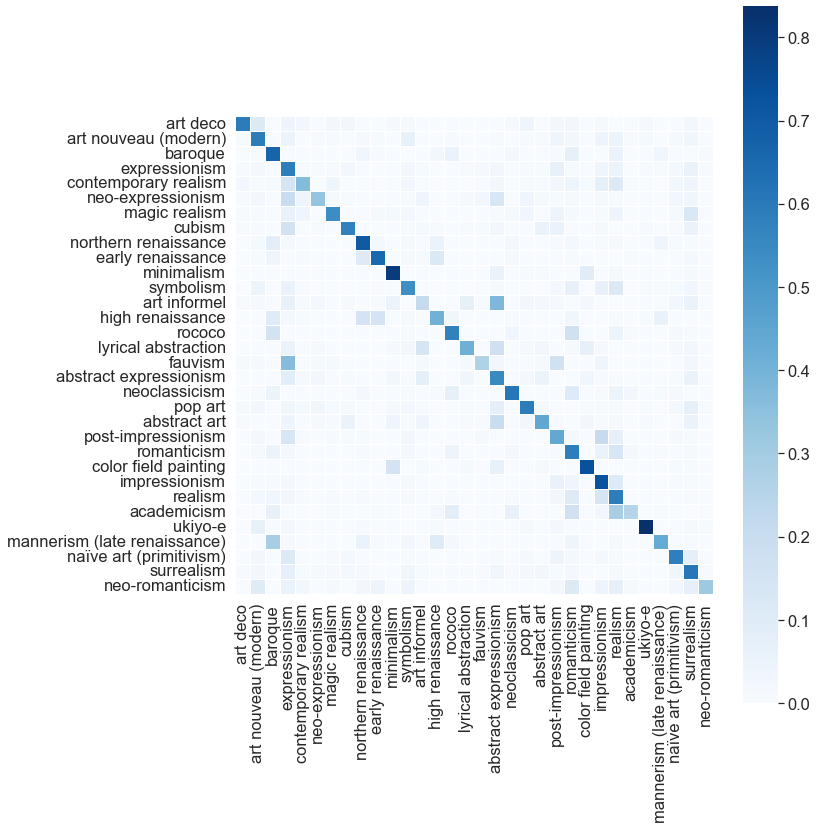

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:02<00:00, 44.23it/s]


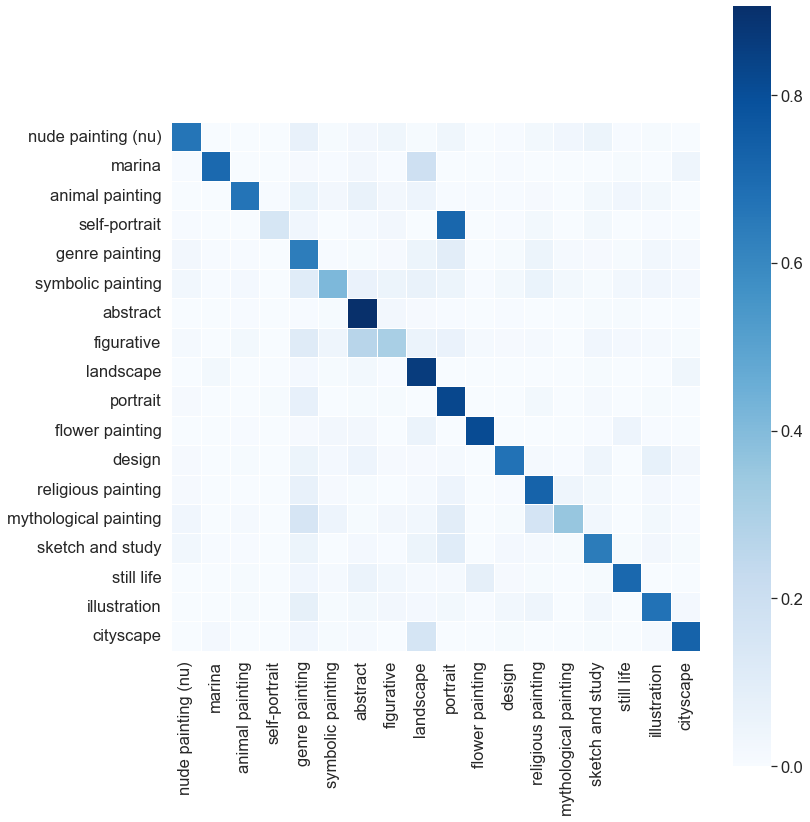

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 41.26it/s]


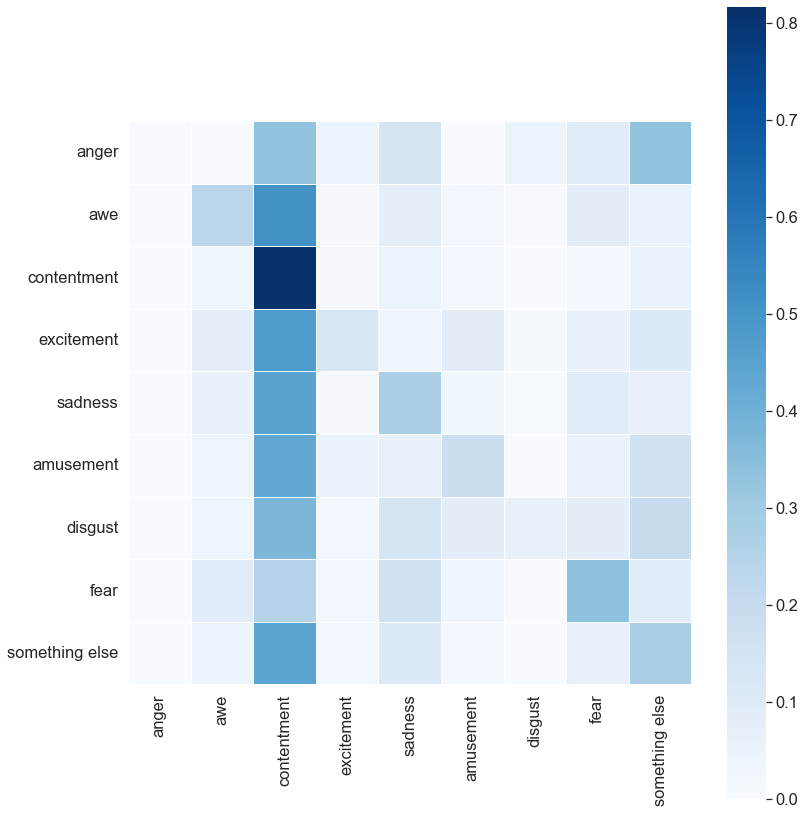

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
batch_size = 128
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    model = torch.load(fr'res_classification/normal/{task}.pt').to(device)
    
    task2name = pd.read_csv(f'artgraph2bestemotions/mapping/{task}_entidx2name.csv', names = ['idx','name'])
    names = task2name['name'].values
    
    test_data = torch.load(fr'dataset_full_conf/test_data_{task}_vit_fine-tuning.pt').to(device)
    test_dataset = ClassificationDataSet(test_data, obj = task)
    test_loader = test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                   drop_last=False, worker_init_fn=np.random.seed(1))
    
    true, pred, history = test(model, test_loader, update_graph = False, track_history = True)
    
    if task == 'genre':
        history_map['normal_no_update'] = history
    pred = pred.numpy()
    results_df['Top1'].loc[task] = compute_topk(true, pred, 1)
    results_df['Top2'].loc[task] = compute_topk(true, pred, 2)
    pred = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(true, pred, average = 'macro')
    plot_confusion_matrix(true, pred, task = task, strategy = 'normal', labels = task2name['name'], hop = map_hop[task])
    #ConfusionMatrixDisplay.from_predictions(true, pred, normalize = 'true', include_values = False)
    plt.show()

In [28]:
results_df

,Top1,Top2,Macro-F1
style,0.582933,0.754293,0.545326
genre,0.723043,0.862895,0.642681
emotion,0.451717,0.642857,0.270228


In [29]:
results_df.to_csv('res_classification/normal_no_update.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 29.44it/s]


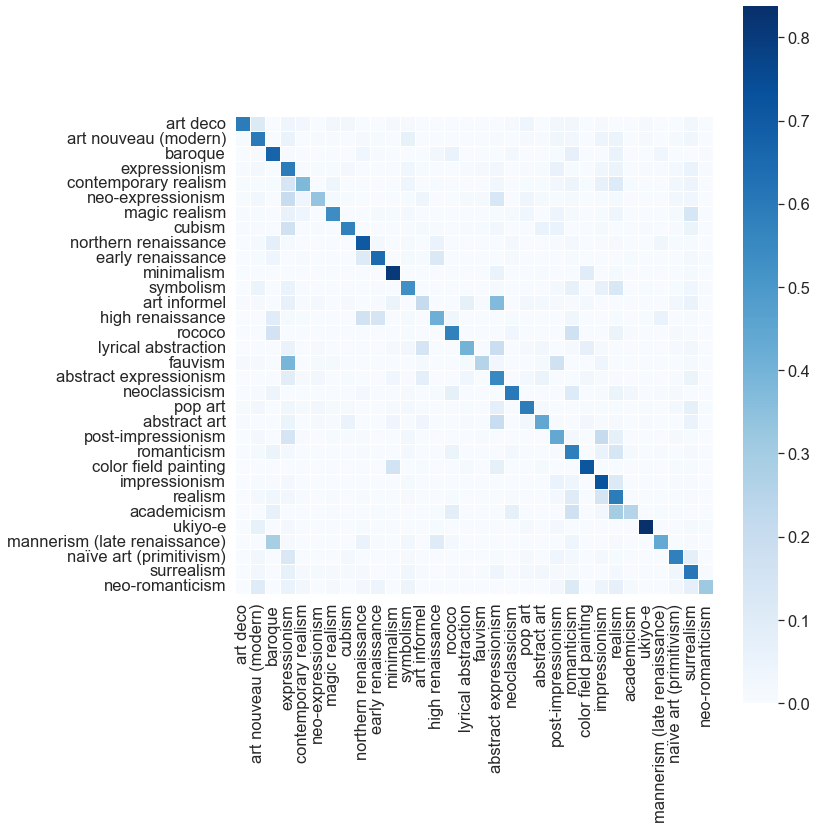

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 27.28it/s]


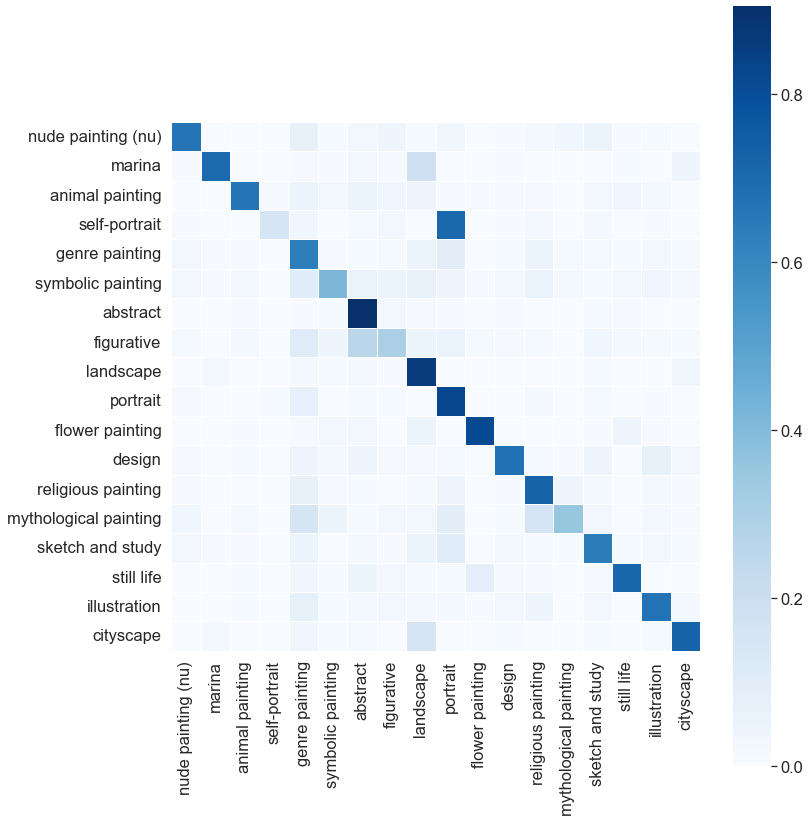

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:02<00:00, 23.36it/s]


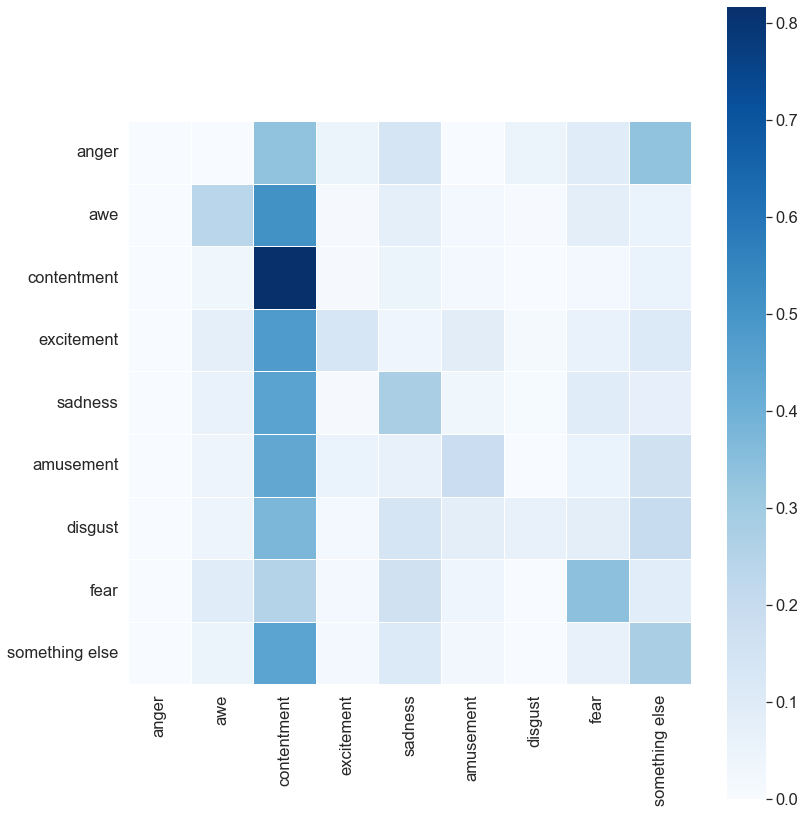

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
batch_size = 128
map_hop={'style':5,
        'genre':3,
        'emotion':2}
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    model = torch.load(fr'res_classification/normal/{task}.pt').to(device)
    
    task2name = pd.read_csv(f'artgraph2bestemotions/mapping/{task}_entidx2name.csv', names = ['idx','name'])
    
    test_data = torch.load(fr'dataset_full_conf/test_data_{task}_vit_fine-tuning.pt').to(device)
    test_dataset = ClassificationDataSet(test_data, obj = task)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, 
                                   drop_last=False)
    
    true, pred, history = test(model, test_loader, update_graph = True, track_history=True, topk = 1)
    
    if task == 'genre':
        history_map['normal_update'] = history
    pred = pred.numpy()
    results_df['Top1'].loc[task] = compute_topk(true, pred, 1)
    results_df['Top2'].loc[task] = compute_topk(true, pred, 2)
    pred = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(true, pred, average = 'macro')
    plot_confusion_matrix(true, pred, task = task, strategy = 'update', labels = task2name['name'], hop = map_hop[task])
    #ConfusionMatrixDisplay.from_predictions(true, pred, normalize = 'true', include_values = False)
    plt.show()

In [22]:
task2name['name'].values

array(['anger', 'awe', 'contentment', 'excitement', 'sadness',
       'amusement', 'disgust', 'fear', 'something else'], dtype=object)

In [23]:
results_df

,Top1,Top2,Macro-F1
style,0.582761,0.753606,0.545753
genre,0.722442,0.862809,0.642405
emotion,0.451563,0.641937,0.270919


In [24]:
results_df

,Top1,Top2,Macro-F1
style,0.582761,0.753606,0.545753
genre,0.722442,0.862809,0.642405
emotion,0.451563,0.641937,0.270919


In [25]:
results_df.to_csv('res_classification/normal_update.csv')

## LEARNING WITH  GRAPH UPDATE DURING VALIDATION

In [24]:
batch_size = 128
update_graph = True
res = {}
if not os.path.exists('res_classification/proposed'):
    os.makedirs('res_classification/proposed')
for task in ('emotion', 'style', 'genre'):
    print(f"{'*'*50}{task.upper()}{'*'*50}")
    train_data, val_data, test_data = import_dataset(root = 'dataset_full_conf', feat='vit', fine_tuning=True,
                                                                 obj=task, device=device)
    model = ModelClassification(train_data, hidden_channels = 128,
                           obj= task, head_num_layers = 5, gnn_activation = nn.Tanh(),
                           head_activation = nn.LeakyReLU, shared = True, gnn_mean = False, bnorm = False,
                           drop_rate = 0.25).to(device)
    
    train_dataset = ClassificationDataSet(train_data, obj = task)
    val_dataset = ClassificationDataSet(val_data, obj = task)
    test_dataset = ClassificationDataSet(test_data, obj = task)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)
    #initialize encoders parameters
    with torch.no_grad():
        model.encoder(train_data.x_dict, train_data.edge_index_dict)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'max', min_lr = 1e-7, verbose = True, factor = .5, patience = 2,
                                               threshold = 1e-4)

    early_stop= EarlyStopping(patience = 7, min_delta = -1e-4)
    best_model, best_acc=fine_tune(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stop, num_epochs = 50,
                                  update_graph = False)
    torch.save(best_model, fr'res_classification/proposed/{task}.pt')
    res[task] = best_acc.item()

**************************************************EMOTION**************************************************


D:\Anaconda\envs\tesi\lib\site-packages\torch_geometric\nn\conv\hetero_conv.py:53: UserWarning: There exist node types ({'artwork'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behaviour.
  warnings.warn(


Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:06<00:00, 58.70it/s]


train Loss: 1.7586 Acc: 0.3855


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.55it/s]


val Loss: 1.6244 Acc: 0.4174
------------------------------------------------------------------------------------------------------------------------

Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.60it/s]


train Loss: 1.6342 Acc: 0.4187


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.00it/s]


val Loss: 1.5880 Acc: 0.4311
------------------------------------------------------------------------------------------------------------------------

Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.28it/s]


train Loss: 1.6034 Acc: 0.4286


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.85it/s]


val Loss: 1.5771 Acc: 0.4352
------------------------------------------------------------------------------------------------------------------------

Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.12it/s]


train Loss: 1.5859 Acc: 0.4346


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.64it/s]


val Loss: 1.5694 Acc: 0.4356
------------------------------------------------------------------------------------------------------------------------

Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.58it/s]


train Loss: 1.5779 Acc: 0.4363


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.71it/s]


val Loss: 1.5636 Acc: 0.4370
------------------------------------------------------------------------------------------------------------------------

Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.29it/s]


train Loss: 1.5682 Acc: 0.4417


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.24it/s]


val Loss: 1.5630 Acc: 0.4370
------------------------------------------------------------------------------------------------------------------------

Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.59it/s]


train Loss: 1.5595 Acc: 0.4431


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.14it/s]


val Loss: 1.5587 Acc: 0.4383
------------------------------------------------------------------------------------------------------------------------

Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.55it/s]


train Loss: 1.5509 Acc: 0.4454


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.85it/s]


val Loss: 1.5573 Acc: 0.4390
------------------------------------------------------------------------------------------------------------------------

Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.81it/s]


train Loss: 1.5424 Acc: 0.4496


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.14it/s]


val Loss: 1.5532 Acc: 0.4397
------------------------------------------------------------------------------------------------------------------------

Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.82it/s]


train Loss: 1.5349 Acc: 0.4491


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.44it/s]


val Loss: 1.5522 Acc: 0.4386
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.67it/s]


train Loss: 1.5287 Acc: 0.4519


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.62it/s]


val Loss: 1.5504 Acc: 0.4400
------------------------------------------------------------------------------------------------------------------------

Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.72it/s]


train Loss: 1.5206 Acc: 0.4550


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.66it/s]


val Loss: 1.5512 Acc: 0.4404
------------------------------------------------------------------------------------------------------------------------

Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.50it/s]


train Loss: 1.5148 Acc: 0.4570


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 88.23it/s]


val Loss: 1.5496 Acc: 0.4398
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 64.02it/s]


train Loss: 1.5057 Acc: 0.4597


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.28it/s]


val Loss: 1.5465 Acc: 0.4380
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 64.01it/s]


train Loss: 1.4955 Acc: 0.4648


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.24it/s]


val Loss: 1.5480 Acc: 0.4411
------------------------------------------------------------------------------------------------------------------------

Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 64.41it/s]


train Loss: 1.4891 Acc: 0.4655


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.49it/s]


val Loss: 1.5466 Acc: 0.4408
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.79it/s]


train Loss: 1.4781 Acc: 0.4691


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.44it/s]


val Loss: 1.5486 Acc: 0.4408
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.66it/s]


train Loss: 1.4683 Acc: 0.4737


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.55it/s]


val Loss: 1.5502 Acc: 0.4389
Epoch 00018: reducing learning rate of group 0 to 5.0000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.62it/s]


train Loss: 1.4489 Acc: 0.4797


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 86.00it/s]


val Loss: 1.5520 Acc: 0.4391
INFO: Early stopping counter 4 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.59it/s]


train Loss: 1.4419 Acc: 0.4804


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 87.55it/s]


val Loss: 1.5568 Acc: 0.4412
------------------------------------------------------------------------------------------------------------------------

Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.45it/s]


train Loss: 1.4350 Acc: 0.4841


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.01it/s]


val Loss: 1.5606 Acc: 0.4392
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 61.90it/s]


train Loss: 1.4288 Acc: 0.4884


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.00it/s]


val Loss: 1.5591 Acc: 0.4392
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.20it/s]


train Loss: 1.4239 Acc: 0.4873


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 82.92it/s]


val Loss: 1.5608 Acc: 0.4396
Epoch 00023: reducing learning rate of group 0 to 2.5000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.13it/s]


train Loss: 1.4109 Acc: 0.4947


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 84.99it/s]


val Loss: 1.5615 Acc: 0.4385
INFO: Early stopping counter 4 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 62.23it/s]


train Loss: 1.4067 Acc: 0.4952


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 89.87it/s]


val Loss: 1.5627 Acc: 0.4367
INFO: Early stopping counter 5 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.13it/s]


train Loss: 1.4066 Acc: 0.4941


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 83.19it/s]


val Loss: 1.5660 Acc: 0.4371
Epoch 00026: reducing learning rate of group 0 to 1.2500e-05.
INFO: Early stopping counter 6 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 357/357 [00:05<00:00, 63.27it/s]


train Loss: 1.3987 Acc: 0.4961


100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [00:01<00:00, 85.35it/s]


val Loss: 1.5651 Acc: 0.4355
INFO: Early stopping counter 7 of 7
------------------------------------------------------------------------------------------------------------------------

Best val Acc: 0.441176
Best epoch: 020
**************************************************STYLE**************************************************
Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 53.03it/s]


train Loss: 2.2434 Acc: 0.3153


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.34it/s]


val Loss: 1.8474 Acc: 0.4123
------------------------------------------------------------------------------------------------------------------------

Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.83it/s]


train Loss: 1.8515 Acc: 0.4124


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.40it/s]


val Loss: 1.7751 Acc: 0.4339
------------------------------------------------------------------------------------------------------------------------

Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.28it/s]


train Loss: 1.7541 Acc: 0.4398


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.14it/s]


val Loss: 1.6906 Acc: 0.4566
------------------------------------------------------------------------------------------------------------------------

Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.20it/s]


train Loss: 1.6915 Acc: 0.4574


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.96it/s]


val Loss: 1.6501 Acc: 0.4671
------------------------------------------------------------------------------------------------------------------------

Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.37it/s]


train Loss: 1.6454 Acc: 0.4713


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.89it/s]


val Loss: 1.6335 Acc: 0.4734
------------------------------------------------------------------------------------------------------------------------

Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.34it/s]


train Loss: 1.6024 Acc: 0.4840


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.63it/s]


val Loss: 1.6071 Acc: 0.4823
------------------------------------------------------------------------------------------------------------------------

Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.10it/s]


train Loss: 1.5690 Acc: 0.4901


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.22it/s]


val Loss: 1.5625 Acc: 0.4945
------------------------------------------------------------------------------------------------------------------------

Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.30it/s]


train Loss: 1.5370 Acc: 0.5010


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.10it/s]


val Loss: 1.5483 Acc: 0.4978
------------------------------------------------------------------------------------------------------------------------

Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.36it/s]


train Loss: 1.5037 Acc: 0.5121


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.09it/s]


val Loss: 1.5571 Acc: 0.4967
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.25it/s]


train Loss: 1.4731 Acc: 0.5197


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.01it/s]


val Loss: 1.5171 Acc: 0.5096
------------------------------------------------------------------------------------------------------------------------

Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 50.86it/s]


train Loss: 1.4443 Acc: 0.5295


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.45it/s]


val Loss: 1.5143 Acc: 0.5113
------------------------------------------------------------------------------------------------------------------------

Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.80it/s]


train Loss: 1.4162 Acc: 0.5372


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.72it/s]


val Loss: 1.5154 Acc: 0.5077
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.82it/s]


train Loss: 1.3902 Acc: 0.5443


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.17it/s]


val Loss: 1.5003 Acc: 0.5165
------------------------------------------------------------------------------------------------------------------------

Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.35it/s]


train Loss: 1.3621 Acc: 0.5533


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.34it/s]


val Loss: 1.4840 Acc: 0.5211
------------------------------------------------------------------------------------------------------------------------

Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 53.06it/s]


train Loss: 1.3369 Acc: 0.5594


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.22it/s]


val Loss: 1.4736 Acc: 0.5206
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.26it/s]


train Loss: 1.3099 Acc: 0.5669


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.71it/s]


val Loss: 1.4816 Acc: 0.5233
------------------------------------------------------------------------------------------------------------------------

Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.23it/s]


train Loss: 1.2888 Acc: 0.5738


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.84it/s]


val Loss: 1.4773 Acc: 0.5221
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.22it/s]


train Loss: 1.2628 Acc: 0.5814


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.84it/s]


val Loss: 1.4682 Acc: 0.5243
------------------------------------------------------------------------------------------------------------------------

Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.36it/s]


train Loss: 1.2388 Acc: 0.5879


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.83it/s]


val Loss: 1.4639 Acc: 0.5265
------------------------------------------------------------------------------------------------------------------------

Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.81it/s]


train Loss: 1.2107 Acc: 0.5977


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 84.65it/s]


val Loss: 1.4478 Acc: 0.5317
------------------------------------------------------------------------------------------------------------------------

Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.86it/s]


train Loss: 1.1902 Acc: 0.6020


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.42it/s]


val Loss: 1.4622 Acc: 0.5314
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.10it/s]


train Loss: 1.1645 Acc: 0.6114


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.00it/s]


val Loss: 1.4382 Acc: 0.5342
------------------------------------------------------------------------------------------------------------------------

Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.94it/s]


train Loss: 1.1439 Acc: 0.6153


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.46it/s]


val Loss: 1.4528 Acc: 0.5340
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.13it/s]


train Loss: 1.1196 Acc: 0.6233


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.61it/s]


val Loss: 1.4830 Acc: 0.5282
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.22it/s]


train Loss: 1.0944 Acc: 0.6307


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.84it/s]


val Loss: 1.4570 Acc: 0.5382
------------------------------------------------------------------------------------------------------------------------

Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.36it/s]


train Loss: 1.0733 Acc: 0.6372


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.84it/s]


val Loss: 1.4678 Acc: 0.5355
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.22it/s]


train Loss: 1.0469 Acc: 0.6458


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 82.54it/s]


val Loss: 1.4611 Acc: 0.5364
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 28/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.03it/s]


train Loss: 1.0269 Acc: 0.6512


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.72it/s]


val Loss: 1.4690 Acc: 0.5367
Epoch 00028: reducing learning rate of group 0 to 5.0000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 29/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.06it/s]


train Loss: 0.9577 Acc: 0.6721


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 77.61it/s]


val Loss: 1.4286 Acc: 0.5508
------------------------------------------------------------------------------------------------------------------------

Epoch 30/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.45it/s]


train Loss: 0.9332 Acc: 0.6802


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.79it/s]


val Loss: 1.4123 Acc: 0.5566
------------------------------------------------------------------------------------------------------------------------

Epoch 31/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 53.21it/s]


train Loss: 0.9161 Acc: 0.6848


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.38it/s]


val Loss: 1.4225 Acc: 0.5556
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 32/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.93it/s]


train Loss: 0.9004 Acc: 0.6921


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 84.85it/s]


val Loss: 1.4170 Acc: 0.5537
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 33/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.51it/s]


train Loss: 0.8833 Acc: 0.6964


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.34it/s]


val Loss: 1.4247 Acc: 0.5545
Epoch 00033: reducing learning rate of group 0 to 2.5000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 34/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.81it/s]


train Loss: 0.8507 Acc: 0.7070


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 84.57it/s]


val Loss: 1.4301 Acc: 0.5639
------------------------------------------------------------------------------------------------------------------------

Epoch 35/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.74it/s]


train Loss: 0.8424 Acc: 0.7094


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 84.53it/s]


val Loss: 1.4190 Acc: 0.5681
------------------------------------------------------------------------------------------------------------------------

Epoch 36/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.71it/s]


train Loss: 0.8318 Acc: 0.7123


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.37it/s]


val Loss: 1.4257 Acc: 0.5683
------------------------------------------------------------------------------------------------------------------------

Epoch 37/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.79it/s]


train Loss: 0.8217 Acc: 0.7171


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.13it/s]


val Loss: 1.4221 Acc: 0.5677
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 38/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.91it/s]


train Loss: 0.8114 Acc: 0.7196


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.37it/s]


val Loss: 1.4293 Acc: 0.5669
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 39/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.42it/s]


train Loss: 0.8082 Acc: 0.7206


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.45it/s]


val Loss: 1.4340 Acc: 0.5668
Epoch 00039: reducing learning rate of group 0 to 1.2500e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 40/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.37it/s]


train Loss: 0.8058 Acc: 0.7203


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 82.06it/s]


val Loss: 1.4160 Acc: 0.5701
------------------------------------------------------------------------------------------------------------------------

Epoch 41/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.17it/s]


train Loss: 0.8017 Acc: 0.7231


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 82.80it/s]


val Loss: 1.4114 Acc: 0.5710
------------------------------------------------------------------------------------------------------------------------

Epoch 42/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.24it/s]


train Loss: 0.7950 Acc: 0.7255


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 82.92it/s]


val Loss: 1.4139 Acc: 0.5707
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 43/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.28it/s]


train Loss: 0.7980 Acc: 0.7246


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.76it/s]


val Loss: 1.4107 Acc: 0.5721
------------------------------------------------------------------------------------------------------------------------

Epoch 44/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.00it/s]


train Loss: 0.7927 Acc: 0.7260


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.65it/s]


val Loss: 1.4187 Acc: 0.5719
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 45/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.75it/s]


train Loss: 0.7831 Acc: 0.7293


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 84.14it/s]


val Loss: 1.4158 Acc: 0.5725
------------------------------------------------------------------------------------------------------------------------

Epoch 46/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.76it/s]


train Loss: 0.7770 Acc: 0.7304


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.72it/s]


val Loss: 1.4213 Acc: 0.5713
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 47/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.25it/s]


train Loss: 0.7761 Acc: 0.7322


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 84.26it/s]


val Loss: 1.4225 Acc: 0.5733
------------------------------------------------------------------------------------------------------------------------

Epoch 48/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 51.91it/s]


train Loss: 0.7716 Acc: 0.7335


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 82.24it/s]


val Loss: 1.4182 Acc: 0.5718
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 49/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.12it/s]


train Loss: 0.7654 Acc: 0.7365


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 84.18it/s]


val Loss: 1.4226 Acc: 0.5729
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 50/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:12<00:00, 52.37it/s]


train Loss: 0.7658 Acc: 0.7339


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.30it/s]


val Loss: 1.4257 Acc: 0.5714
Epoch 00050: reducing learning rate of group 0 to 6.2500e-06.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Best val Acc: 0.573317
Best epoch: 047
**************************************************GENRE**************************************************
Epoch 1/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.29it/s]


train Loss: 1.4251 Acc: 0.5733


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.00it/s]


val Loss: 1.0910 Acc: 0.6505
------------------------------------------------------------------------------------------------------------------------

Epoch 2/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.06it/s]


train Loss: 1.1237 Acc: 0.6517


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.83it/s]


val Loss: 1.0381 Acc: 0.6666
------------------------------------------------------------------------------------------------------------------------

Epoch 3/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.18it/s]


train Loss: 1.0705 Acc: 0.6656


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.34it/s]


val Loss: 1.0200 Acc: 0.6727
------------------------------------------------------------------------------------------------------------------------

Epoch 4/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.86it/s]


train Loss: 1.0387 Acc: 0.6737


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.48it/s]


val Loss: 0.9993 Acc: 0.6788
------------------------------------------------------------------------------------------------------------------------

Epoch 5/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.48it/s]


train Loss: 1.0098 Acc: 0.6803


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.01it/s]


val Loss: 0.9826 Acc: 0.6838
------------------------------------------------------------------------------------------------------------------------

Epoch 6/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.69it/s]


train Loss: 0.9895 Acc: 0.6850


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 84.93it/s]


val Loss: 0.9812 Acc: 0.6825
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 7/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.64it/s]


train Loss: 0.9720 Acc: 0.6909


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.80it/s]


val Loss: 0.9663 Acc: 0.6865
------------------------------------------------------------------------------------------------------------------------

Epoch 8/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.76it/s]


train Loss: 0.9548 Acc: 0.6949


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.06it/s]


val Loss: 0.9612 Acc: 0.6867
------------------------------------------------------------------------------------------------------------------------

Epoch 9/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.83it/s]


train Loss: 0.9367 Acc: 0.7001


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.44it/s]


val Loss: 0.9491 Acc: 0.6943
------------------------------------------------------------------------------------------------------------------------

Epoch 10/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.95it/s]


train Loss: 0.9219 Acc: 0.7027


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.29it/s]


val Loss: 0.9467 Acc: 0.6943
------------------------------------------------------------------------------------------------------------------------

Epoch 11/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.05it/s]


train Loss: 0.9076 Acc: 0.7077


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.51it/s]


val Loss: 0.9424 Acc: 0.6945
------------------------------------------------------------------------------------------------------------------------

Epoch 12/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.23it/s]


train Loss: 0.8928 Acc: 0.7137


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.18it/s]


val Loss: 0.9354 Acc: 0.6967
------------------------------------------------------------------------------------------------------------------------

Epoch 13/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.09it/s]


train Loss: 0.8765 Acc: 0.7167


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.05it/s]


val Loss: 0.9287 Acc: 0.6994
------------------------------------------------------------------------------------------------------------------------

Epoch 14/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.01it/s]


train Loss: 0.8619 Acc: 0.7199


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.46it/s]


val Loss: 0.9306 Acc: 0.6977
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 15/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.35it/s]


train Loss: 0.8479 Acc: 0.7241


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.84it/s]


val Loss: 0.9259 Acc: 0.6999
------------------------------------------------------------------------------------------------------------------------

Epoch 16/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.66it/s]


train Loss: 0.8330 Acc: 0.7292


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.73it/s]


val Loss: 0.9239 Acc: 0.7008
------------------------------------------------------------------------------------------------------------------------

Epoch 17/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.04it/s]


train Loss: 0.8213 Acc: 0.7331


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.84it/s]


val Loss: 0.9237 Acc: 0.7024
------------------------------------------------------------------------------------------------------------------------

Epoch 18/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.48it/s]


train Loss: 0.8077 Acc: 0.7372


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.23it/s]


val Loss: 0.9318 Acc: 0.7012
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 19/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.43it/s]


train Loss: 0.7953 Acc: 0.7401


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.01it/s]


val Loss: 0.9182 Acc: 0.7041
------------------------------------------------------------------------------------------------------------------------

Epoch 20/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.27it/s]


train Loss: 0.7808 Acc: 0.7433


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.97it/s]


val Loss: 0.9260 Acc: 0.6999
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 21/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 58.99it/s]


train Loss: 0.7682 Acc: 0.7475


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.38it/s]


val Loss: 0.9226 Acc: 0.7038
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 22/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.54it/s]


train Loss: 0.7526 Acc: 0.7521


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.37it/s]


val Loss: 0.9272 Acc: 0.7021
Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 23/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.92it/s]


train Loss: 0.7159 Acc: 0.7624


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.29it/s]


val Loss: 0.9188 Acc: 0.7057
------------------------------------------------------------------------------------------------------------------------

Epoch 24/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.11it/s]


train Loss: 0.7054 Acc: 0.7675


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.97it/s]


val Loss: 0.9207 Acc: 0.7093
------------------------------------------------------------------------------------------------------------------------

Epoch 25/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.42it/s]


train Loss: 0.6980 Acc: 0.7689


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.81it/s]


val Loss: 0.9177 Acc: 0.7091
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 26/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.25it/s]


train Loss: 0.6897 Acc: 0.7708


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.01it/s]


val Loss: 0.9232 Acc: 0.7099
------------------------------------------------------------------------------------------------------------------------

Epoch 27/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:11<00:00, 57.65it/s]


train Loss: 0.6802 Acc: 0.7727


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.97it/s]


val Loss: 0.9308 Acc: 0.7081
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 28/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.27it/s]


train Loss: 0.6701 Acc: 0.7754


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.10it/s]


val Loss: 0.9277 Acc: 0.7089
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 29/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 58.92it/s]


train Loss: 0.6620 Acc: 0.7793


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.65it/s]


val Loss: 0.9355 Acc: 0.7063
Epoch 00029: reducing learning rate of group 0 to 2.5000e-05.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 30/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.11it/s]


train Loss: 0.6412 Acc: 0.7848


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.01it/s]


val Loss: 0.9241 Acc: 0.7119
------------------------------------------------------------------------------------------------------------------------

Epoch 31/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.26it/s]


train Loss: 0.6364 Acc: 0.7865


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.05it/s]


val Loss: 0.9286 Acc: 0.7120
------------------------------------------------------------------------------------------------------------------------

Epoch 32/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.92it/s]


train Loss: 0.6321 Acc: 0.7889


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 84.50it/s]


val Loss: 0.9282 Acc: 0.7109
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 33/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.43it/s]


train Loss: 0.6231 Acc: 0.7910


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.44it/s]


val Loss: 0.9349 Acc: 0.7115
Epoch 00033: reducing learning rate of group 0 to 1.2500e-05.
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 34/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.35it/s]


train Loss: 0.6192 Acc: 0.7917


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 83.95it/s]


val Loss: 0.9259 Acc: 0.7151
------------------------------------------------------------------------------------------------------------------------

Epoch 35/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 58.99it/s]


train Loss: 0.6167 Acc: 0.7940


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.41it/s]


val Loss: 0.9310 Acc: 0.7135
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 36/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.06it/s]


train Loss: 0.6127 Acc: 0.7940


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.13it/s]


val Loss: 0.9245 Acc: 0.7148
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 37/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.40it/s]


train Loss: 0.6136 Acc: 0.7930


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.76it/s]


val Loss: 0.9301 Acc: 0.7141
Epoch 00037: reducing learning rate of group 0 to 6.2500e-06.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 38/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.38it/s]


train Loss: 0.6133 Acc: 0.7920


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.61it/s]


val Loss: 0.9239 Acc: 0.7164
------------------------------------------------------------------------------------------------------------------------

Epoch 39/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.64it/s]


train Loss: 0.6138 Acc: 0.7927


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.73it/s]


val Loss: 0.9238 Acc: 0.7170
------------------------------------------------------------------------------------------------------------------------

Epoch 40/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.85it/s]


train Loss: 0.6117 Acc: 0.7941


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.30it/s]


val Loss: 0.9235 Acc: 0.7163
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 41/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 60.29it/s]


train Loss: 0.6061 Acc: 0.7949


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.79it/s]


val Loss: 0.9230 Acc: 0.7174
------------------------------------------------------------------------------------------------------------------------

Epoch 42/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.85it/s]


train Loss: 0.6073 Acc: 0.7963


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.00it/s]


val Loss: 0.9250 Acc: 0.7169
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 43/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.98it/s]


train Loss: 0.6090 Acc: 0.7948


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.50it/s]


val Loss: 0.9246 Acc: 0.7166
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 44/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.68it/s]


train Loss: 0.6071 Acc: 0.7953


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 85.25it/s]


val Loss: 0.9242 Acc: 0.7166
Epoch 00044: reducing learning rate of group 0 to 3.1250e-06.
INFO: Early stopping counter 3 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 45/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.73it/s]


train Loss: 0.6039 Acc: 0.7961


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.89it/s]


val Loss: 0.9243 Acc: 0.7174
------------------------------------------------------------------------------------------------------------------------

Epoch 46/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.79it/s]


train Loss: 0.6034 Acc: 0.7979


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.10it/s]


val Loss: 0.9252 Acc: 0.7172
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 47/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.42it/s]


train Loss: 0.6033 Acc: 0.7961


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 88.53it/s]


val Loss: 0.9230 Acc: 0.7170
Epoch 00047: reducing learning rate of group 0 to 1.5625e-06.
INFO: Early stopping counter 2 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 48/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.71it/s]


train Loss: 0.6020 Acc: 0.7974


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.75it/s]


val Loss: 0.9237 Acc: 0.7176
------------------------------------------------------------------------------------------------------------------------

Epoch 49/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.55it/s]


train Loss: 0.5997 Acc: 0.7982


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 86.30it/s]


val Loss: 0.9246 Acc: 0.7175
INFO: Early stopping counter 1 of 7
------------------------------------------------------------------------------------------------------------------------

Epoch 50/50
------------------------------------------------------------------------------------------------------------------------


100%|████████████████████████████████████████████████████████████████████████████████| 637/637 [00:10<00:00, 59.23it/s]


train Loss: 0.6012 Acc: 0.7972


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:02<00:00, 87.93it/s]

val Loss: 0.9234 Acc: 0.7180
------------------------------------------------------------------------------------------------------------------------

Best val Acc: 0.717977
Best epoch: 050


In [25]:
res

{'emotion': 0.4411764705882353,
 'style': 0.5733173076923077,
 'genre': 0.7179773351648352}

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:01<00:00, 76.53it/s]


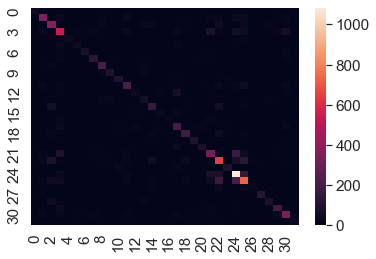

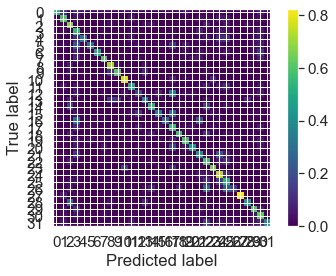

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:01<00:00, 72.91it/s]


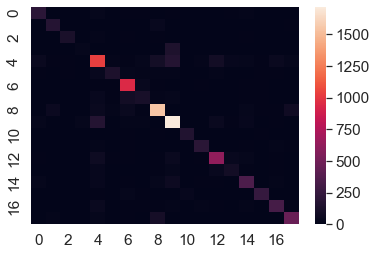

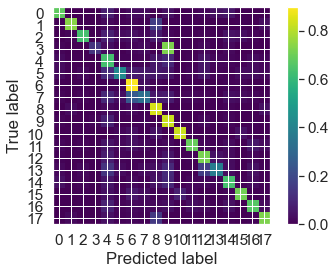

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 47.31it/s]


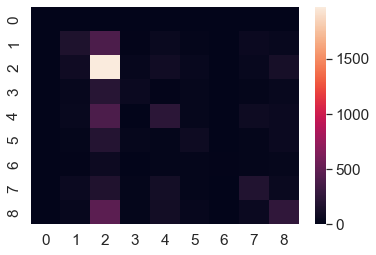

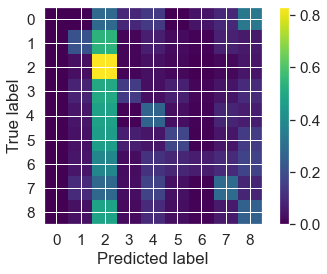

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
batch_size = 128
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    model = torch.load(fr'res_classification/proposed/{task}.pt').to(device)
    test_data = torch.load(fr'dataset_full_conf/test_data_{task}_vit_fine-tuning.pt').to(device)
    test_dataset = ClassificationDataSet(test_data, obj = task)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)
    
    true, pred, history = test(model, test_loader, update_graph = False, track_history = True)
    
    if task == 'genre':
        history_map['proposed_no_update'] = history
    
    pred = pred.numpy()
    results_df['Top1'].loc[task] = compute_topk(true, pred, 1)
    results_df['Top2'].loc[task] = compute_topk(true, pred, 2)
    pred = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(true, pred, average = 'macro')
    plot_confusion_matrix(true, pred)
    ConfusionMatrixDisplay.from_predictions(true, pred, normalize = 'true', include_values = False)
    plt.show()

In [27]:
results_df

,Top1,Top2,Macro-F1
style,0.571257,0.748025,0.535082
genre,0.719609,0.862809,0.642698
emotion,0.446812,0.642091,0.262482


In [28]:
results_df.to_csv('res_classification/proposed_no_update.csv')

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 27.53it/s]


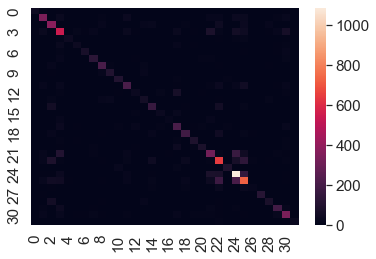

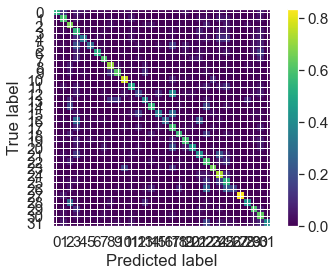

100%|██████████████████████████████████████████████████████████████████████████████████| 91/91 [00:03<00:00, 26.38it/s]


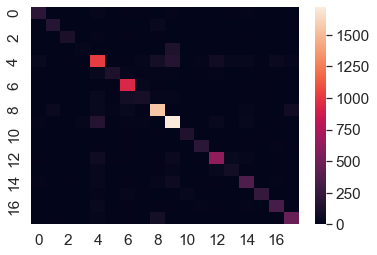

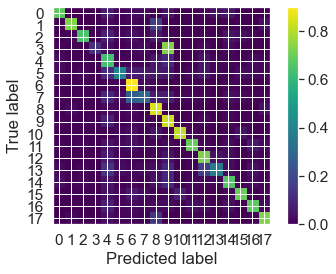

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 37.03it/s]


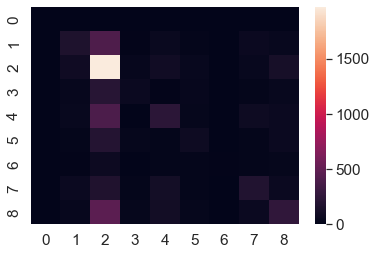

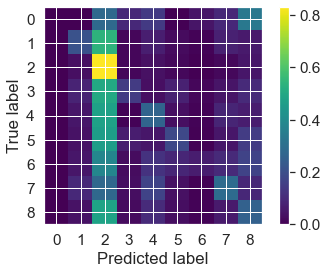

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
batch_size = 128
results_df = pd.DataFrame(columns = ['Top1', 'Top2', 'Macro-F1'], index = ('style', 'genre', 'emotion'))
for task in ('style', 'genre', 'emotion'):
    model = torch.load(fr'res_classification/proposed/{task}.pt').to(device)
    
    test_data = torch.load(fr'dataset_full_conf/test_data_{task}_vit_fine-tuning.pt').to(device)
    test_dataset = ClassificationDataSet(test_data, obj = task)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                                   drop_last=False)
    
    true, pred, history = test(model, test_loader, update_graph = True, track_history = True)
    
    if task == 'genre':
        history_map['proposed_update'] = history
    pred = pred.numpy()
    results_df['Top1'].loc[task] = compute_topk(true, pred, 1)
    results_df['Top2'].loc[task] = compute_topk(true, pred, 2)
    pred = torch.max(torch.Tensor(pred), 1)[1]
    results_df['Macro-F1'].loc[task] = f1_score(true, pred, average = 'macro')
    plot_confusion_matrix(true, pred)
    ConfusionMatrixDisplay.from_predictions(true, pred, normalize = 'true', include_values = False)
    plt.show()

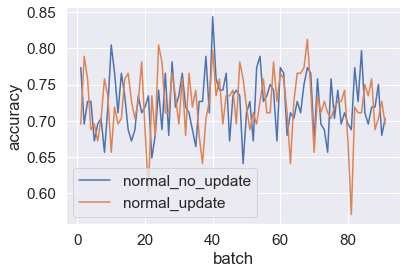

In [39]:
for type_val, data in filter(lambda x: 'normal' in x[0], history_map.items()):
    plt.plot(list(range(1, len(data) + 1)),  data, label = type_val)
plt.legend()
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()

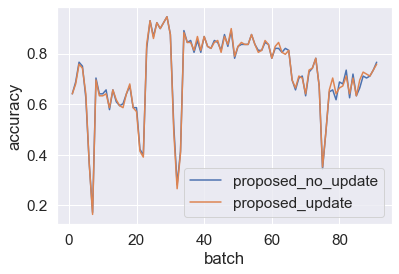

In [31]:
for type_val, data in filter(lambda x: 'proposed' in x[0], history_map.items()):
    plt.plot(list(range(1, len(data) + 1)), data, label = type_val)
plt.legend()
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()

In [32]:
results_df

,Top1,Top2,Macro-F1
style,0.571171,0.747596,0.535367
genre,0.719952,0.864526,0.64184
emotion,0.446812,0.641478,0.262613


In [33]:
results_df.to_csv('res_classification/proposed_update.csv')

In [34]:
normal = pd.read_csv('res_classification/normal_no_update.csv', index_col = 0)
normal

,Top1,Top2,Macro-F1
style,0.582933,0.754293,0.545326
genre,0.723043,0.862895,0.642681
emotion,0.451717,0.642857,0.270228


In [35]:
normal_update= pd.read_csv('res_classification/normal_update.csv', index_col = 0)
normal_update

,Top1,Top2,Macro-F1
style,0.582246,0.753777,0.544062
genre,0.721669,0.862981,0.640855
emotion,0.451870,0.642704,0.270558


In [36]:
proposed = pd.read_csv('res_classification/proposed_no_update.csv', index_col = 0)
proposed

,Top1,Top2,Macro-F1
style,0.571257,0.748025,0.535082
genre,0.719609,0.862809,0.642698
emotion,0.446812,0.642091,0.262482


In [37]:
proposed_update = pd.read_csv('res_classification/proposed_update.csv', index_col = 0)
proposed_update

,Top1,Top2,Macro-F1
style,0.571171,0.747596,0.535367
genre,0.719952,0.864526,0.641840
emotion,0.446812,0.641478,0.262613


Results: **for tasks in which the absolute value of accurarcy is higher** (that is to say, not much noise is added into the graph), **adding links can boost performances**